<a href="https://colab.research.google.com/github/chumpblocckami/RelatedToML/blob/master/ImageRetrival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install -q keras==2.2.4

TensorFlow 1.x selected.
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-672pml4e
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-672pml4e
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=e30742e1cedf8c41975ab8e329bb799b9510e17b783484f7dc399be132fbdd1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-sxkddxex/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [3]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv 

#keras
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.applications import VGG19
import keras.preprocessing.image as kimage

#data manipulation
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

#save
import pickle
import copy

#no print of errors and stuff like that
tf.get_logger().setLevel('WARNING') 

Using TensorFlow backend.


In [4]:
class MyRetriver():

  model = None
  model_name = ""
  faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")  
  centroids = None

  def select_model(self,string):
    '''Possible models:
      - VGG19 from keras
      - VGGFace with resnet
      - VGG Face  with imagenet
      '''
    if string == "vggface":
      print("using vggface")
      net = VGGFace(model='resnet50',
              include_top=False,
              pooling='avg',
              input_shape=(224, 224, 3))
      self.model = net
      self.model_name = "vggface"
      
    elif string == "vggface_vgg16":
      print("using vgg19")
      net = VGGFace(model='vgg16')
      self.model = net
      self.model_name = "vggface_vgg16"

    else:
      print("using default vgg19")
      net = VGG19(include_top=False,
                  weights="imagenet",
                  input_tensor=None,
                  input_shape=None,
                  pooling=None)
      self.model = net
      self.model_name = "vgg19"

  def neural_features(self,img):
    '''
      neural features based on model chosen
    '''
    x= kimage.img_to_array(img)

    if self.model_name == "vggface_vgg16":
      x = utils.preprocess_input(x, version=1) #for vgg
    elif self.model_name == "vggface":
      x = utils.preprocess_input(x, version=2) #for resnet
    else:
      x = utils.preprocess_input(x)

    x = np.expand_dims(x,axis = 0)
    f= self.model.predict(x)
    return f.flatten()

  def identity(self,image):
    return image

  def load_data(self,path, only_faces=False, maximages = 100,  feature_extractor=neural_features):
    '''
    Data loader:
    It load every .jpg images in every folder, and will extract the neural features.
    If only_faces is true, will return only the faces of the images 
    maximages is the number of images for every class
    Folder structure:
    -Class1
      |--item.jpg
      |--item1.jpg
      |--...
      -Class2
      |--xxx.jpg
      |--yzx.jpg
      |--...
      -...
    '''
    base_path = path

    self.paths = []
    self.features = []
    self.labels = []
    self.faces = []

    for fi,f in enumerate(sorted(os.listdir(base_path))): #cicla tutti i file
        for fi,images in enumerate(sorted(os.listdir(base_path+f))):
          #se l'immagine è un .jpg
          if images.endswith('.jpg') and fi<maximages:
              # Memorizza percorso file
              cur_path = base_path + f + "/" + images
              # Carica file ed estraine le features
              image = np.array(kimage.load_img(cur_path, target_size=(224, 224)))
              if only_faces:
                faces_crop = self.faceCascade.detectMultiScale(image, scaleFactor=1.1, minSize=(30, 30))
                #trovo le facce all'interno della foto
                if len(faces_crop) >= 1:
                  for (x, y, w, h) in faces_crop:
                    #trovo gli occhi
                    # eyes = eyeCascade.detectMultiScale(image[y:y + h, x:x + w])
                    # if (len(eyes)>=1):
                    roi_color = image[y:y + h, x:x + w]
                    roi_color = cv.cvtColor(roi_color, cv.COLOR_BGR2RGB)
                    cropped_image = cv.resize(roi_color,(224,224))
                    cur_features = feature_extractor(self,cropped_image)
                    self.faces.append(cropped_image)
              else:
                cur_features = feature_extractor(self,image)
                self.faces.append(None)
                    
              #Salviamo i risultati
              self.features.append(cur_features)
              self.paths.append(cur_path)
              self.labels.append(f)
        print(f)
    self.features = np.array(self.features)
    for i in os.listdir(base_path):
      x = x+len(os.listdir(base_path+"/"+i))
    print("Images in folder processed:",x)
    print("Images processed",len(self.features))

  def checkmodel(self):
    return self.features.shape

  def getCentroids(self,feature_selection = False,k=100):
    '''
    Returns the centroid.
    If feature_selection is selected, it will perform a KBest feature selection with a given k,
    otherwise none is applied.
    '''
    if feature_selection:
      KBest = SelectKBest(chi2, k=k)
      self.X_new =  KBest.fit_transform(self.features, self.labels)
    else:
      self.X_new = self.features

    self.df = pd.DataFrame([[x] for x in self.X_new],self.labels).reset_index()
    self.df.columns=["Name","Neural Features"]
    self.df["Paths"] = self.paths

    self.centers = []
    for i in set(self.labels):
      base = self.df.loc[self.df["Name"]==i]["Neural Features"].tolist()
      kmeans = KMeans(n_clusters=1, random_state=126).fit(base)
      self.centers.append(kmeans.cluster_centers_[0])

  def getViz(self,string,query_image=None):
    '''
      get visualisation based on whats you want:
      - 'images': visualize where every person is placed
      - 'centroids': visualize where every centroids is placed
      - 'query': visualize where the query image is placed. Needs the query image
    '''

    if string == 'images':
      pca = PCA(n_components=2)
      self.features_pca = pca.fit_transform(self.X_new)
      le = LabelEncoder()
      self.colorLabel = le.fit_transform(self.labels)
      plt.scatter([x[0] for x in self.features_pca],[x[1] for x in self.features_pca],c=self.colorLabel)

    if string == "centroids":
      if self.centroids == None:
        self.getCentroids()
      pca = PCA(n_components=2)
      centers_ = pca.fit_transform(self.centers)
      le = LabelEncoder()
      labels_color_ = le.fit_transform(list(set(self.labels)))
      plt.scatter([x[0] for x in centers_],[x[1] for x in centers_],c=labels_color_)

      for i in range(len(centers_)): 
        plt.text(x=centers_[i][0],y=centers_[i][1],s=list(set(self.labels))[i])

    if string == "query":
      if query_image == None:
        print("No Query image selected.")
        return 
      if self.centroids == None:
        self.getCentroids()

      centers_tmp = copy.copy(self.centers)
      centers_tmp.append(self.neural_features(kimage.load_img(query_image, target_size=(224,224))))
      labels_tmp = copy.copy(self.labels)
      labels_tmp.append("QUERY IMAGE")

      pca = PCA(n_components=2)
      centers_ = pca.fit_transform(centers_tmp)
      le = LabelEncoder()
      labels_color_ = le.fit_transform(list(set(labels_tmp)))
      plt.scatter([x[0] for x in centers_],[x[1] for x in centers_],c=labels_color_)

      for i in range(len(centers_tmp)): 
        plt.text(x=centers_[i][0],y=centers_[i][1],s=list(set(labels_tmp))[i])

    return plt

  def getRetrieval(self,path_to_image,cropped=True):
    '''
    Retrieve the image based on the tree.
    First it query the three based on centroids, then query the tree based on images of the given centroids
    path_to_image: string that presents the file
    cropped: if false, it will crop the image. Will raise errors if there are too much or no faces in the images
    '''
    if cropped==True:
      img = kimage.load_img(path_to_image, target_size=(224,224))
      img = np.array(img)
    else:
      img = kimage.load_img(path_to_image, target_size=(224,224))
      img = np.array(img)
      faces_crop = self.faceCascade.detectMultiScale(img, scaleFactor=1.1, minSize=(30, 30))
        #trovo le facce all'interno della foto
      if len(faces_crop) > 1 or len(faces_crop) == 0:
        print("Too much or no face detected! Using the image as a hole")
        img = img
      else:
        for (x, y, w, h) in faces_crop:
          roi_color = img[y:y + h, x:x + w]
          roi_color = cv.cvtColor(roi_color, cv.COLOR_BGR2RGB)
          img = cv.resize(roi_color,(224,224))
          img = np.array(img)

    query_feature = self.neural_features(img)
    query_feature = np.expand_dims(query_feature, axis = 0)  

    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    #assert len(self.centers[0]) == len(query_feature)

    self.base_tree = KDTree(np.array(self.centers))
    dis, ind = self.base_tree.query(query_feature, k=1)
    print(dis,ind)
    print("Nome:",list(set(self.labels))[ind[0][0]])

    name = list(set(self.labels))[ind[0][0]]
    sub_data = np.array(self.df.loc[self.df["Name"]==name]["Neural Features"].tolist())

    self.sub_tree = KDTree(sub_data)
    dis_, ind_ = self.sub_tree.query(query_feature,k=1)
    print(dis_,ind_)
    
    paths_augmented = [self.df.loc[self.df["Name"]==name]["Paths"].tolist()[x] for x in ind_[0]]
    images_augmented = [kimage.load_img(x) for x in paths_augmented]
    plt.imshow(images_augmented[0])
    plt.show()

  def save_data_to_file(self,path,name_features="MYR_features",name_labels = "MYR_labels",name_paths="MYR_paths"):
    '''
      Save data to file. Can save to multiple files.
    '''
    with open(path+"/"+name_features+".pkl",'wb') as f:
      pickle.dump(self.features, f)
    with open(path+"/"+name_labels+".pkl",'wb') as f:
      pickle.dump(self.labels, f)
    with open(path+"/"+name_paths+".pkl",'wb') as f:
      pickle.dump(self.paths, f)
  def save_data_to_csv(self,path):
    if df != None:
      self.df.to_csv(path+"/MYR_df.csv")
    else:
      self.getCentroids()
      self.df.to_csv(path+"/MYR_df.csv")

  def load_data_from_file(self,path,path_to_file="",path_to_labels="",path_to_paths=""):
    '''
      Load data from pickle. Can load from multiple files
    '''
    path_to_file = path+"MYR_features.pkl"
    path_to_labels = path+"MYR_labels.pkl"
    path_to_paths = path+"MYR_paths.pkl"
    with open(path_to_file,'rb') as f:
      features_ = pickle.load(f)
    self.features = features_
    with open(path_to_labels,'rb') as f:
      labels_ = pickle.load(f)
    self.labels = labels_
    with open(path_to_paths,'rb') as f:
      paths_ = pickle.load(f)
    self.paths = paths_

In [5]:
myr = MyRetriver()
myr.select_model("vggface")  if myr.model == None else "No need to load models"

path = "drive/My Drive/attori_famosi/"
if ("MYR_features.pkl" in os.listdir(path)):
  print("Load files...")
  myr.load_data_from_file("drive/My Drive/attori_famosi/")
else:
  print("Init")
  path = "drive/My Drive/attori_famosi/thumbnails_features_deduped_sample/"
  myr.load_data(path,only_faces=True)
  myr.save_data_to_file("drive/My Drive/attori_famosi/")

myr.getCentroids(feature_selection=False)

using vggface













Load files...


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

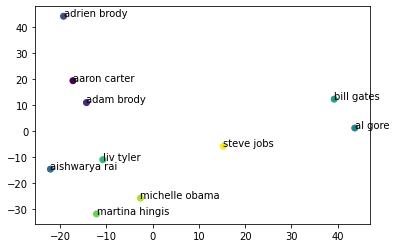

In [6]:
myr.getViz("centroids")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

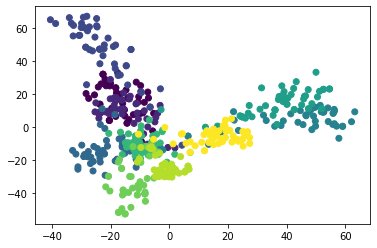

In [7]:
myr.getViz("images")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

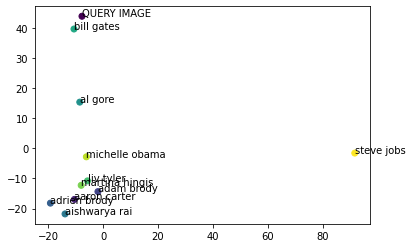

In [8]:
myr.getViz('query','drive/My Drive/56_massi_cropped.jpg')

--2020-09-15 20:52:06--  https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Liv_Tyler_2%2C_2007.jpg/220px-Liv_Tyler_2%2C_2007.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15347 (15K) [image/jpeg]
Saving to: ‘220px-Liv_Tyler_2,_2007.jpg.13’

220px-Liv_Tyler_2,_ 100%[===================>]  14.99K  --.-KB/s    in 0.002s  

2020-09-15 20:52:07 (5.96 MB/s) - ‘220px-Liv_Tyler_2,_2007.jpg.13’ saved [15347/15347]

220px-Liv_Tyler_2,_2007.jpg


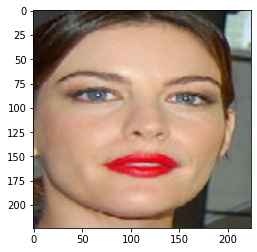

[[72.30192593]] [[3]]
Nome: liv tyler
[[73.20824428]] [[17]]


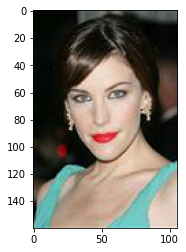

In [9]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Liv_Tyler_2%2C_2007.jpg/220px-Liv_Tyler_2%2C_2007.jpg
new_image = "".join([x for x in os.listdir() if x.endswith(".jpg")][0])
print(new_image)

myr.getRetrieval(new_image,cropped=False)